# Filter Delta2 Data Caulobacter crescentus fast imaging
 
In this notebook we filter the time-lapse data of Caulobacter crescentus mutant strains with cdg sensor growing on agar-pads imaged at high time resolution

filtering is done using the custom filter_tracks function provided in filter_tracks.py file.

---

## Import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

from filter_tracks import filter_tracks

---

## Setup Folders

In [2]:
image_dir = pathlib.Path.cwd() / 'images'
save_dir = pathlib.Path.cwd() / 'data_files'

---

## Load Data
We load the data files of the individual colonies and merge them together.

In [3]:
csv_path = save_dir / 'caulobacter_fast_combined_data_low_dens.csv'
df = pd.read_csv(csv_path)

We add a unique ID for each cell pair (two cells with shared parent) by combining strain id, replicate id, and par id

In [4]:
#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()

,Unnamed: 0,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,...,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,0,-1,0,1,492,-1,0,[ 18 971],...,115.156010,992.979540,14.265985,0.0,0,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
1,1,0,0,-1,0,1,492,-1,1,[ 18 974],...,116.523438,993.010417,13.898438,0.0,1,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
2,2,0,0,-1,0,1,492,-1,2,[ 17 971],...,115.984375,993.117188,13.489583,0.0,2,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
3,3,0,0,-1,0,1,492,-1,3,[ 17 971],...,115.661538,993.097436,13.325641,0.0,3,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
4,4,0,0,-1,0,1,492,-1,4,[ 17 973],...,117.321053,993.092105,12.973684,0.0,4,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1


---

## Check data

We first plot the life time distribution full lineages (those with parent and two offspring)


(0.0, 100.0)

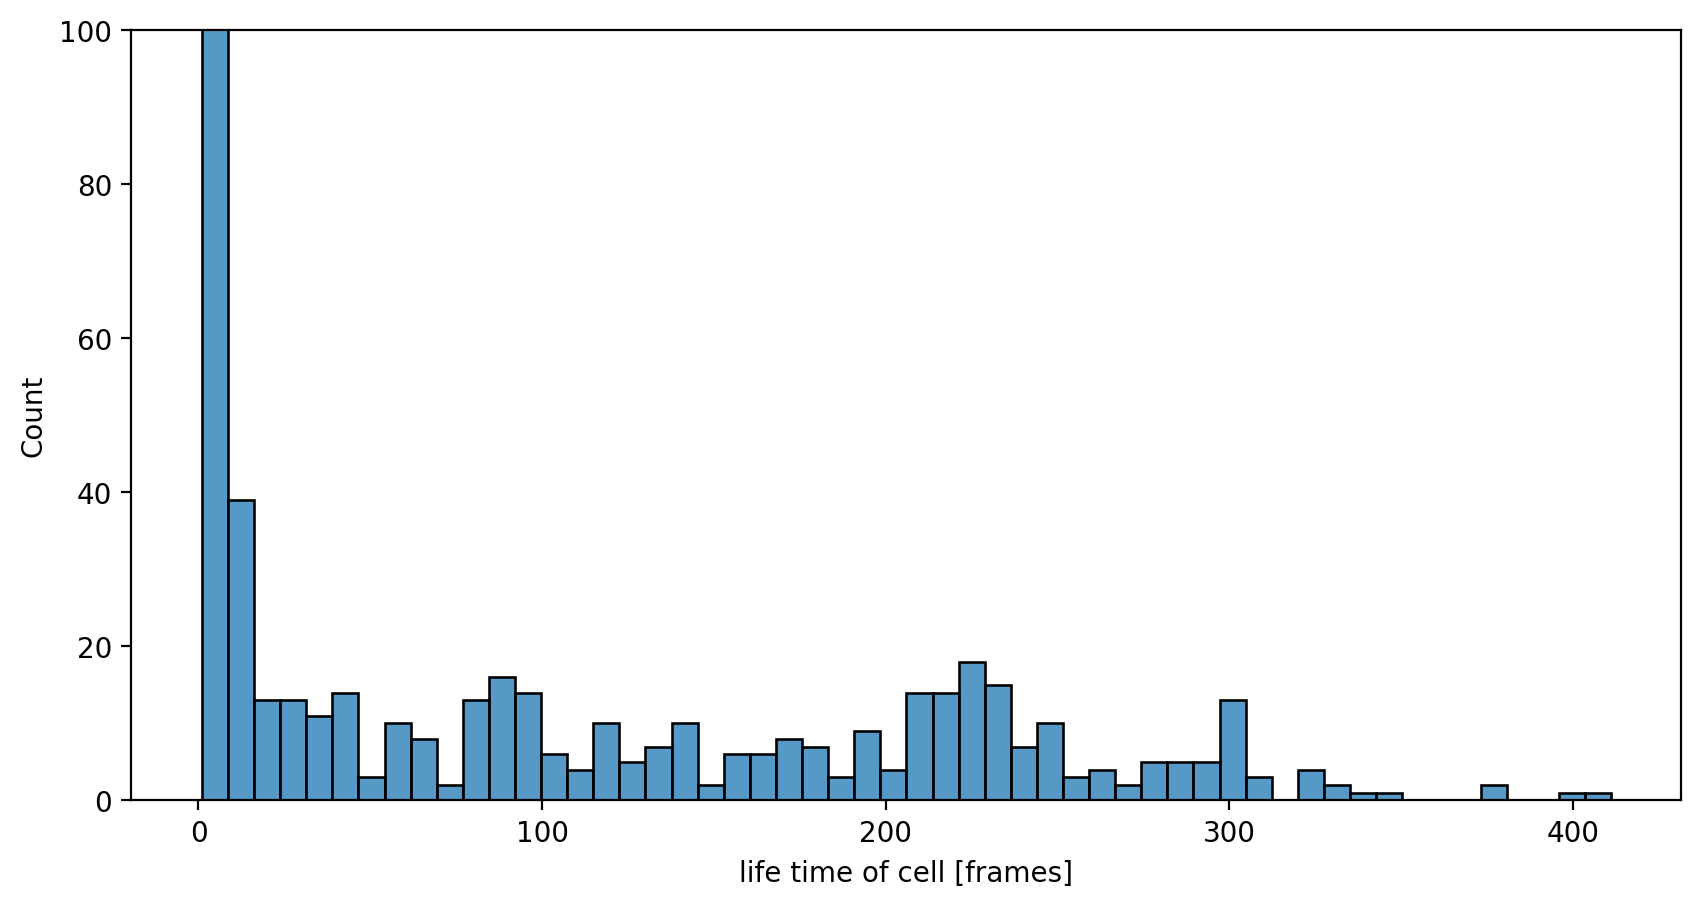

In [5]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
full_lin = has_mom 

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size())
ax.set_xlabel('life time of cell [frames]');
ax.set_ylim([0,100])

Next we analyze the change in length between two frames

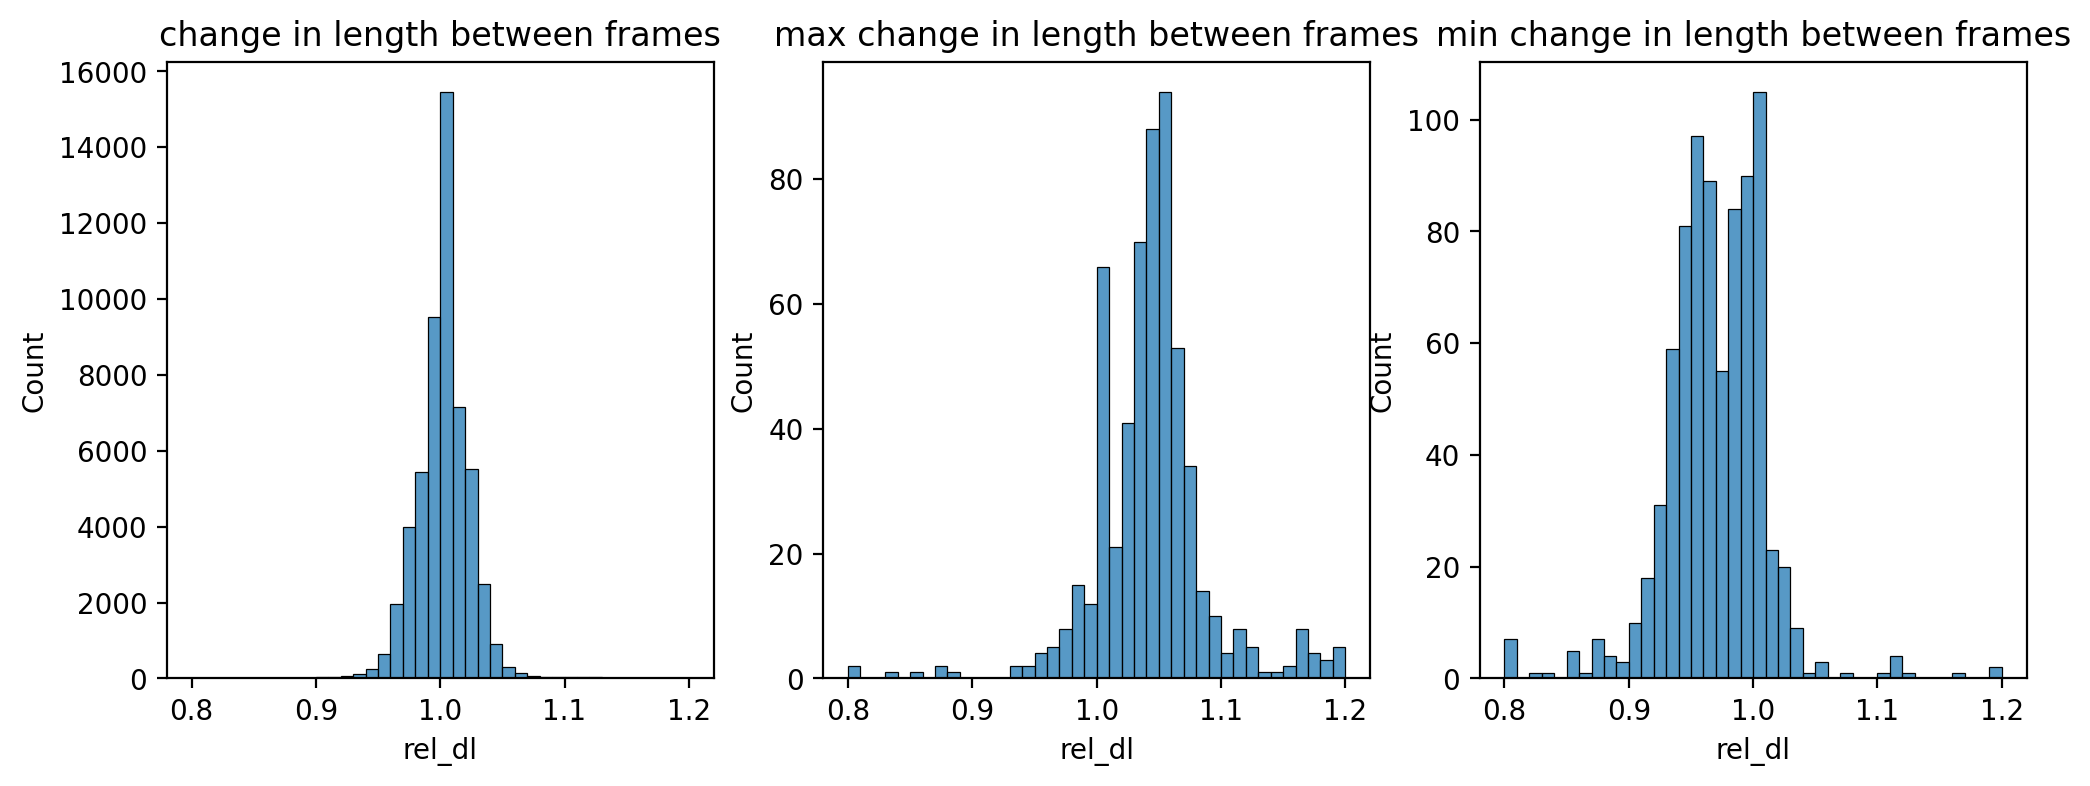

In [6]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41)).set(title='change in length between frames')
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41)).set(title='max change in length between frames')
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41)).set(title='min change in length between frames');

Next we analyze the change in length across cell divisions 

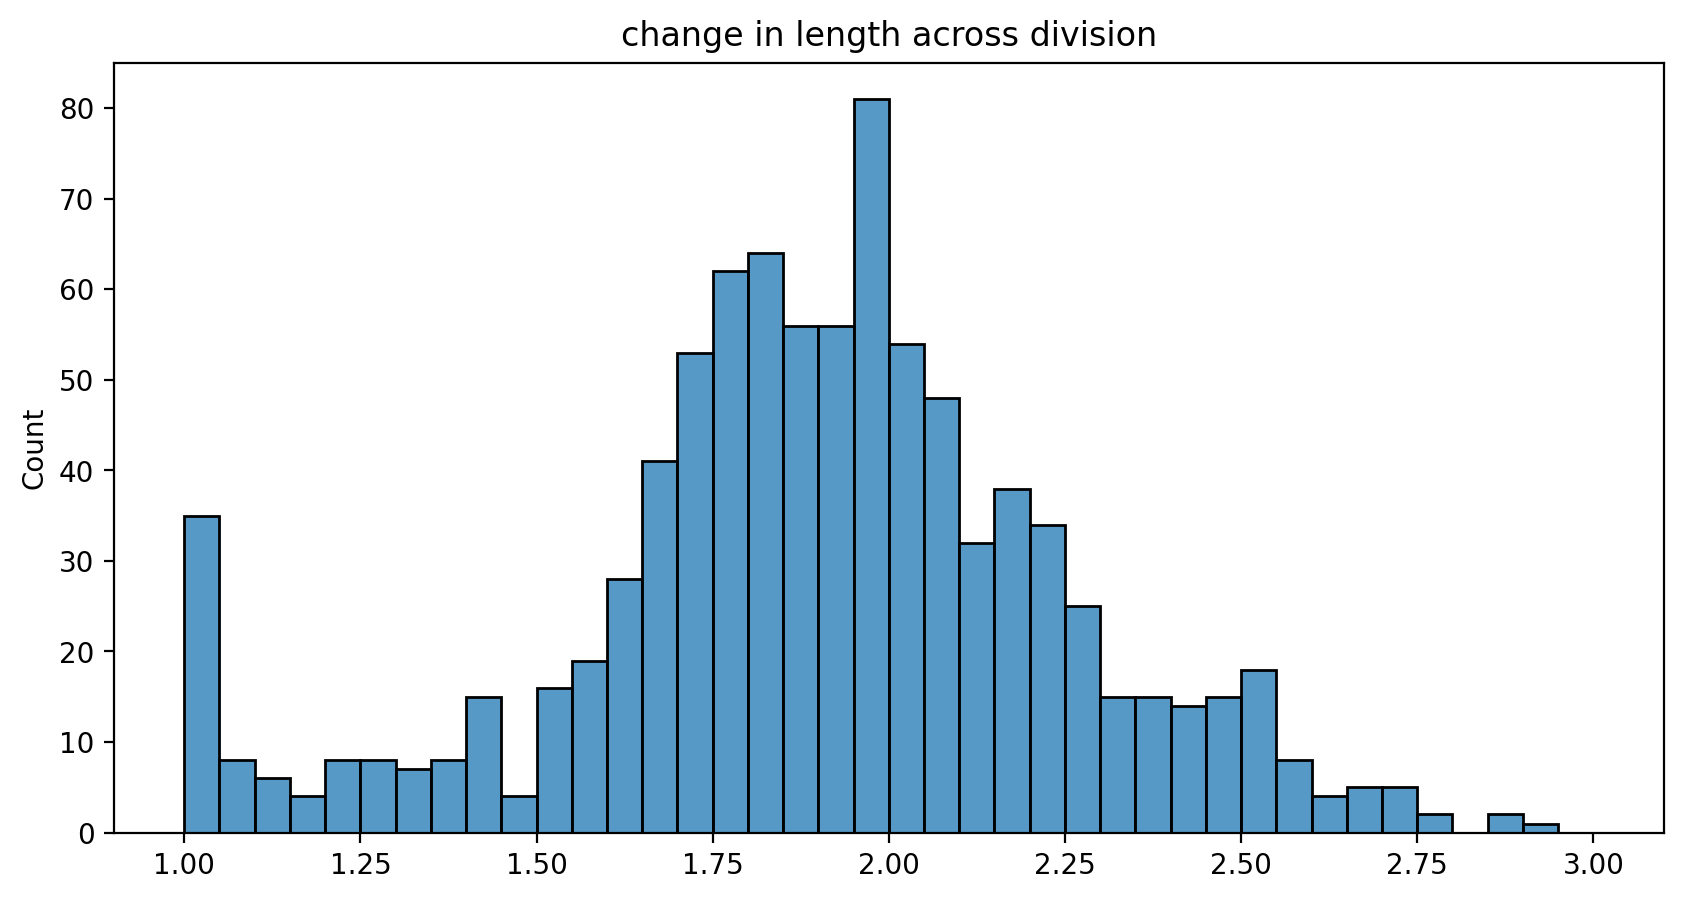

In [7]:
#analyze change in length
dl_list = []
movies_grouped = df_compl.groupby('movie_name')

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    for name, cell in cells_grouped:
        
        try:
            par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
            
            #get length
            len_cel = cell['length'].iloc[0]
            len_par = movie.loc[par_idx, 'length'].iloc[-1]
        
            dl_list.append(len_par / len_cel)
        except:
            continue

sns.histplot(data=dl_list, bins=np.linspace(1,3,41)).set(title='change in length across division');

---

## Filter data

We filter individual cell tracks to check for segmentation and tracking errors.

We use following checks:
 - We only consider cells who have a parent and that have been tracked for `Min_num_frames` frames
 - We filter out lineages where the length changes too much during life time
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$
 - We filter out lineages where cell length of parent is too far from expected value (should be between `min_par_len` to `max_par_len` as big as daughter cell directly after division) to filter out tracking errors.

These are the filter settings we use:

- `min_par_len` = 1.5 : the minimal value of the relative length of the parent (to make sure we start at cell-division)
- `max_par_len` = 2.5 : the maximum value of the relative length of the parent (to make sure we start at cell-division)
- `max_dl` = 1.08 : max value $l(t+1)/l(t)$ 
- `min_dl` = 0.92 : min value $l(t+1)/l(t)$ 
- `min_num_frm` = 60 : min number of frames to track 
- `cdg_ch`: cdg channel name

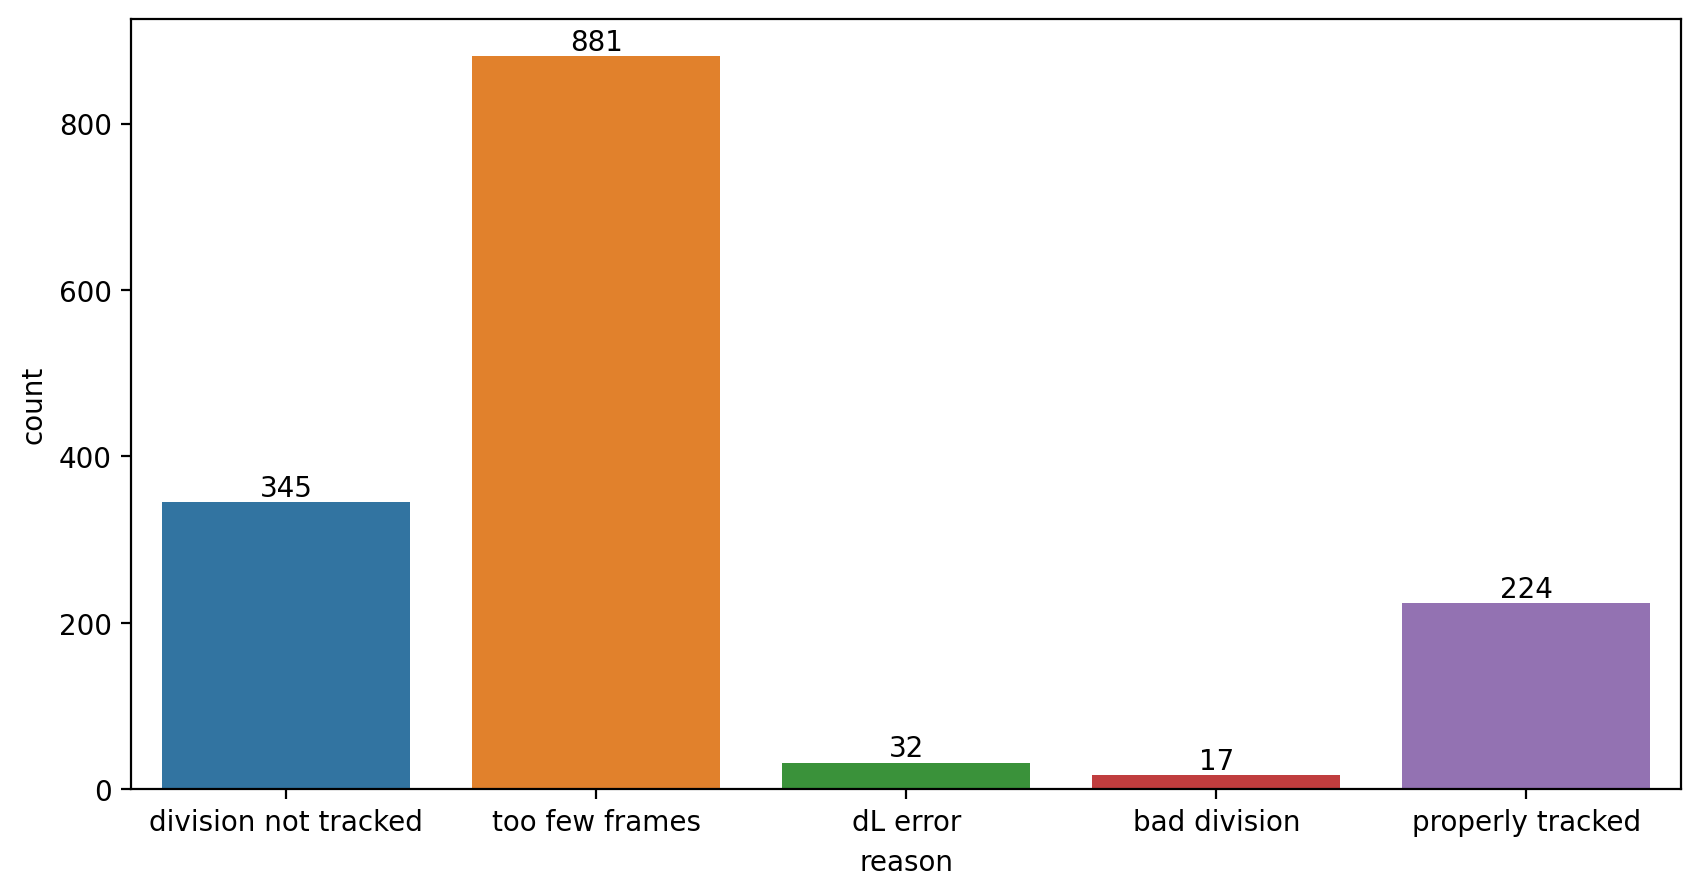

In [8]:
#filter settings
filter_par = {
        'max_par_len' : 2.5,
        'min_par_len' : 1.5,
        'max_dl': 1.08,  
        'min_dl': 0.92,  
        'min_num_frm': 60,
        'max_num_frm' : 120,
        'cdg_ch': 'fluo1'}


#keep track of why lineages are skipped
reason_skipped = { \
        'division not tracked':0,
        'too few frames':0,
        'dL error':0,
        'bad division':0,
        'properly tracked':0}

#init output
df_list = []

cells_grouped = df.groupby('uni_id') 
for _, cur_cell in cells_grouped:
        # filter cells    
        new_df = filter_tracks(df, cur_cell, filter_par, reason_skipped)
        if new_df is not None:
                df_list.append(new_df)
        
              
df_filtered = pd.concat(df_list) if len(df_list)>0 else None   

df_filtered['time since birth [min]'] = df_filtered['age'] * 0.5
df_filtered = df_filtered.reset_index(drop=True)

out_name = save_dir / 'filtered_data_Cc_Fast.csv'
df_filtered.to_csv(out_name)
 
df_stats = pd.DataFrame( [ [k,v] for k,v in reason_skipped.items()],columns=['reason','count'])
ax = sns.barplot(data=df_stats, x='reason', y='count')
ax.bar_label(ax.containers[0]);